<a href="https://colab.research.google.com/github/pedroezequiellima/Predi-o-de-Risco-de-AVC-com-Ciencia-de-Dados-/blob/main/MinicursoAnalisedeDados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ciencia de Dados


Analise de Dados       


## Introdução

[Stroke dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

Segundo a Organização Mundial da Saúde (OMS), o AVC é a segunda principal causa de morte no mundo, sendo responsável por aproximadamente 11% do total de mortes. Este conjunto de dados é usado para prever a probabilidade de um paciente sofrer um AVC com base em parâmetros de entrada como sexo, idade, diversas doenças e tabagismo. Cada linha dos dados fornece informações relevantes sobre o paciente.

## Estudo de Caso

Utilização de 11 características clínicas para prever eventos de AVC

### 1. Importações das bibliotecas

In [15]:
# 1. importacoes

# data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# análises estatísticas
from scipy.stats import probplot, normaltest

# preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# machine learning modeling
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# warnings
import warnings
warnings.filterwarnings('ignore')

### 2. Analise de dados

#### 2.1. Carregamento da base de dados

In [16]:
# 2. carregar dataset original e criar cópia de segurança
df_raw = pd.read_csv(r'/content/healthcare-dataset-stroke-data.csv')
df = df_raw.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#### 2.2. Manipulação e preparação da base de dados

In [17]:
# 3. manipulacao de dados
## excluir coluna de id
df.drop(columns=['id'], axis=1, inplace=True)

In [18]:
## traduzir nomes das colunas para pt-br
df.columns = ['genero', 'idade', 'hipertenso', 'cardiaco', 'casado', 'ocupacao', 'zoneamento', 'glicemia', 'imc', 'fumante', 'avc']

In [19]:
## traduzir os valores de cada coluna categórica
num_cols = ['idade', 'glicemia', 'imc']
cat_cols = [col for col in df.columns if col not in num_cols]
#cat_cols

In [20]:
### Passo 1: identificar valores únicos das colunas categóricas
for i in range(len(cat_cols)):
    print(f'Coluna: {cat_cols[i] :10} | Valores: {df[cat_cols[i]].unique()}')

Coluna: genero     | Valores: ['Male' 'Female' 'Other']
Coluna: hipertenso | Valores: [0 1]
Coluna: cardiaco   | Valores: [1 0]
Coluna: casado     | Valores: ['Yes' 'No']
Coluna: ocupacao   | Valores: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Coluna: zoneamento | Valores: ['Urban' 'Rural']
Coluna: fumante    | Valores: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
Coluna: avc        | Valores: [1 0]


In [21]:
cols_map = df.select_dtypes(exclude='number').columns
cols_map

Index(['genero', 'casado', 'ocupacao', 'zoneamento', 'fumante'], dtype='object')

In [22]:
### Passo 2: criar dicionários para traduzir valores categóricos
genero_map = {'Male': 'M', 'Female': 'F', 'Other': 'Outro'}
casado_map = {'Yes': 'S', 'No': 'N'}
ocupacao_map = {'Private':'CLT', 'Self-employed':'autonomo','Govt_job':'funcpubl', 'children':'menor', 'Never_worked': 'nuncatrab'}
zoneamento_map = {'Urban': 'urbano', 'Rural': 'rural'}
fumante_map = {'formerly smoked': 'ex-fumante', 'never smoked': 'nuncafumou', 'smokes': 'fumante', 'Unknown':'desconhecido'}

list_map = [genero_map, casado_map, ocupacao_map,
            zoneamento_map, fumante_map]

In [23]:
### Passo 3: aplicar transformação
for i in range(len(cols_map)):
    df[cols_map[i]].replace(to_replace=list_map[i], inplace=True)

In [24]:
df.head()

,genero,idade,hipertenso,cardiaco,casado,ocupacao,zoneamento,glicemia,imc,fumante,avc
0,M,67.0,0,1,S,CLT,urbano,228.69,36.6,ex-fumante,1
1,F,61.0,0,0,S,autonomo,rural,202.21,NaN,nuncafumou,1
2,M,80.0,0,1,S,CLT,rural,105.92,32.5,nuncafumou,1
3,F,49.0,0,0,S,CLT,urbano,171.23,34.4,fumante,1
4,F,79.0,1,0,S,autonomo,rural,174.12,24.0,nuncafumou,1


In [25]:
# 4. verificar valores nulos/ausentes/inconsistentes
df.isnull().sum()

,0
genero,0
idade,0
hipertenso,0
cardiaco,0
casado,0
ocupacao,0
zoneamento,0
glicemia,0
imc,201
fumante,0


In [26]:
df['genero'].value_counts()
#df['fumante'].value_counts()

,count
genero,
F,2994
M,2115
Outro,1


In [27]:
## Estratégia 1: excluir observações (linhas)
print('antes', df.shape[0])
#df.dropna(subset=['imc'], inplace=True)
print('depois', df.shape[0])

antes 5110
depois 5110


In [28]:
## Estratégia 2: preencher com valor representativo (média ou mediana)

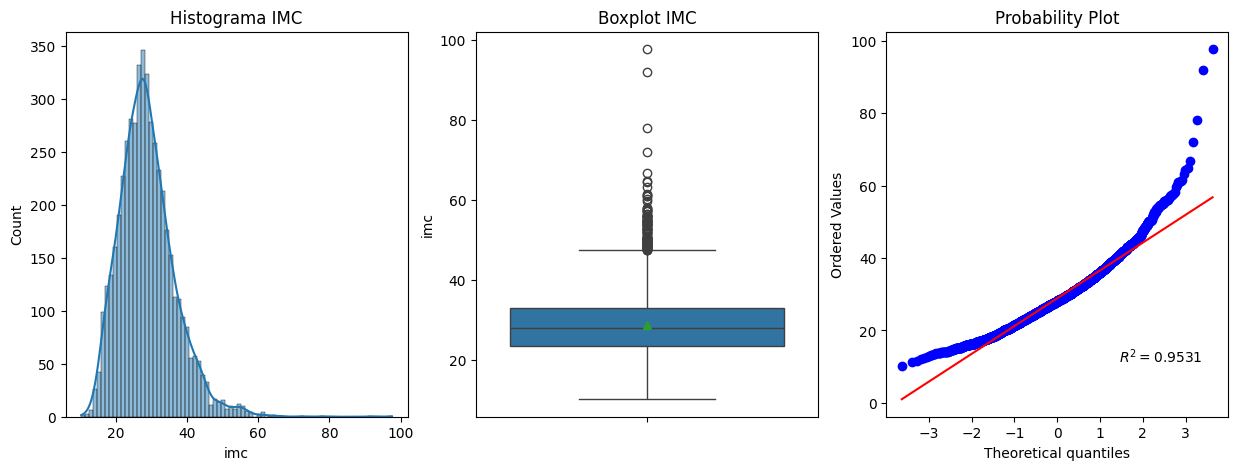

In [29]:
# verificando pressupostos de normalidade
plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.histplot(data=df, x='imc', kde=True)
plt.title('Histograma IMC');

plt.subplot(132)
sns.boxplot(data=df['imc'].dropna(), showmeans=True)
plt.title('Boxplot IMC');

plt.subplot(133)
probplot(x=df['imc'].dropna(), plot=plt, rvalue=True, fit=True);

In [30]:
df['imc'].fillna(value=df['imc'].median(), inplace=True)

In [31]:
df.isnull().sum()

,0
genero,0
idade,0
hipertenso,0
cardiaco,0
casado,0
ocupacao,0
zoneamento,0
glicemia,0
imc,0
fumante,0


In [32]:
# 5. Excluir a linha referente ao rótulo 'outro' da coluna genero
df.loc[df['genero'] == 'Outro']

,genero,idade,hipertenso,cardiaco,casado,ocupacao,zoneamento,glicemia,imc,fumante,avc
3116,Outro,26.0,0,0,N,CLT,rural,143.33,22.4,ex-fumante,0


In [33]:
print('antes', df.shape[0])
df.drop(index=3116, axis=0, inplace=True)
print('depois', df.shape[0])

antes 5110
depois 5109


#### 2.3. Análise exploratória de dados (EDA)

In [34]:
# 6. EDA
## visão geral (head/info/describe)
df.head()

,genero,idade,hipertenso,cardiaco,casado,ocupacao,zoneamento,glicemia,imc,fumante,avc
0,M,67.0,0,1,S,CLT,urbano,228.69,36.6,ex-fumante,1
1,F,61.0,0,0,S,autonomo,rural,202.21,28.1,nuncafumou,1
2,M,80.0,0,1,S,CLT,rural,105.92,32.5,nuncafumou,1
3,F,49.0,0,0,S,CLT,urbano,171.23,34.4,fumante,1
4,F,79.0,1,0,S,autonomo,rural,174.12,24.0,nuncafumou,1


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   genero      5109 non-null   object 
 1   idade       5109 non-null   float64
 2   hipertenso  5109 non-null   int64  
 3   cardiaco    5109 non-null   int64  
 4   casado      5109 non-null   object 
 5   ocupacao    5109 non-null   object 
 6   zoneamento  5109 non-null   object 
 7   glicemia    5109 non-null   float64
 8   imc         5109 non-null   float64
 9   fumante     5109 non-null   object 
 10  avc         5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.0+ KB


In [36]:
df[['idade', 'glicemia', 'imc']].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
idade,5109.0,43.23,22.61,0.08,25.00,45.00,61.00,82.00
glicemia,5109.0,106.14,45.29,55.12,77.24,91.88,114.09,271.74
imc,5109.0,28.86,7.70,10.30,23.80,28.10,32.80,97.60


In [37]:
df.describe(include='object').T

,count,unique,top,freq
genero,5109,2,F,2994
casado,5109,2,S,3353
ocupacao,5109,5,CLT,2924
zoneamento,5109,2,urbano,2596
fumante,5109,4,nuncafumou,1892


In [38]:
display(df['hipertenso'].value_counts())
display(df['cardiaco'].value_counts())

,count
hipertenso,
0,4611
1,498


,count
cardiaco,
0,4833
1,276


In [39]:
## análise univariada categórica
### criação de listas de variaveis para iterações
cols = df.columns.tolist()
num_cols = ['idade', 'glicemia', 'imc']
cat_cols = [col for col in cols if col not in num_cols ]

cols, num_cols, cat_cols

(['genero',
  'idade',
  'hipertenso',
  'cardiaco',
  'casado',
  'ocupacao',
  'zoneamento',
  'glicemia',
  'imc',
  'fumante',
  'avc'],
 ['idade', 'glicemia', 'imc'],
 ['genero',
  'hipertenso',
  'cardiaco',
  'casado',
  'ocupacao',
  'zoneamento',
  'fumante',
  'avc'])

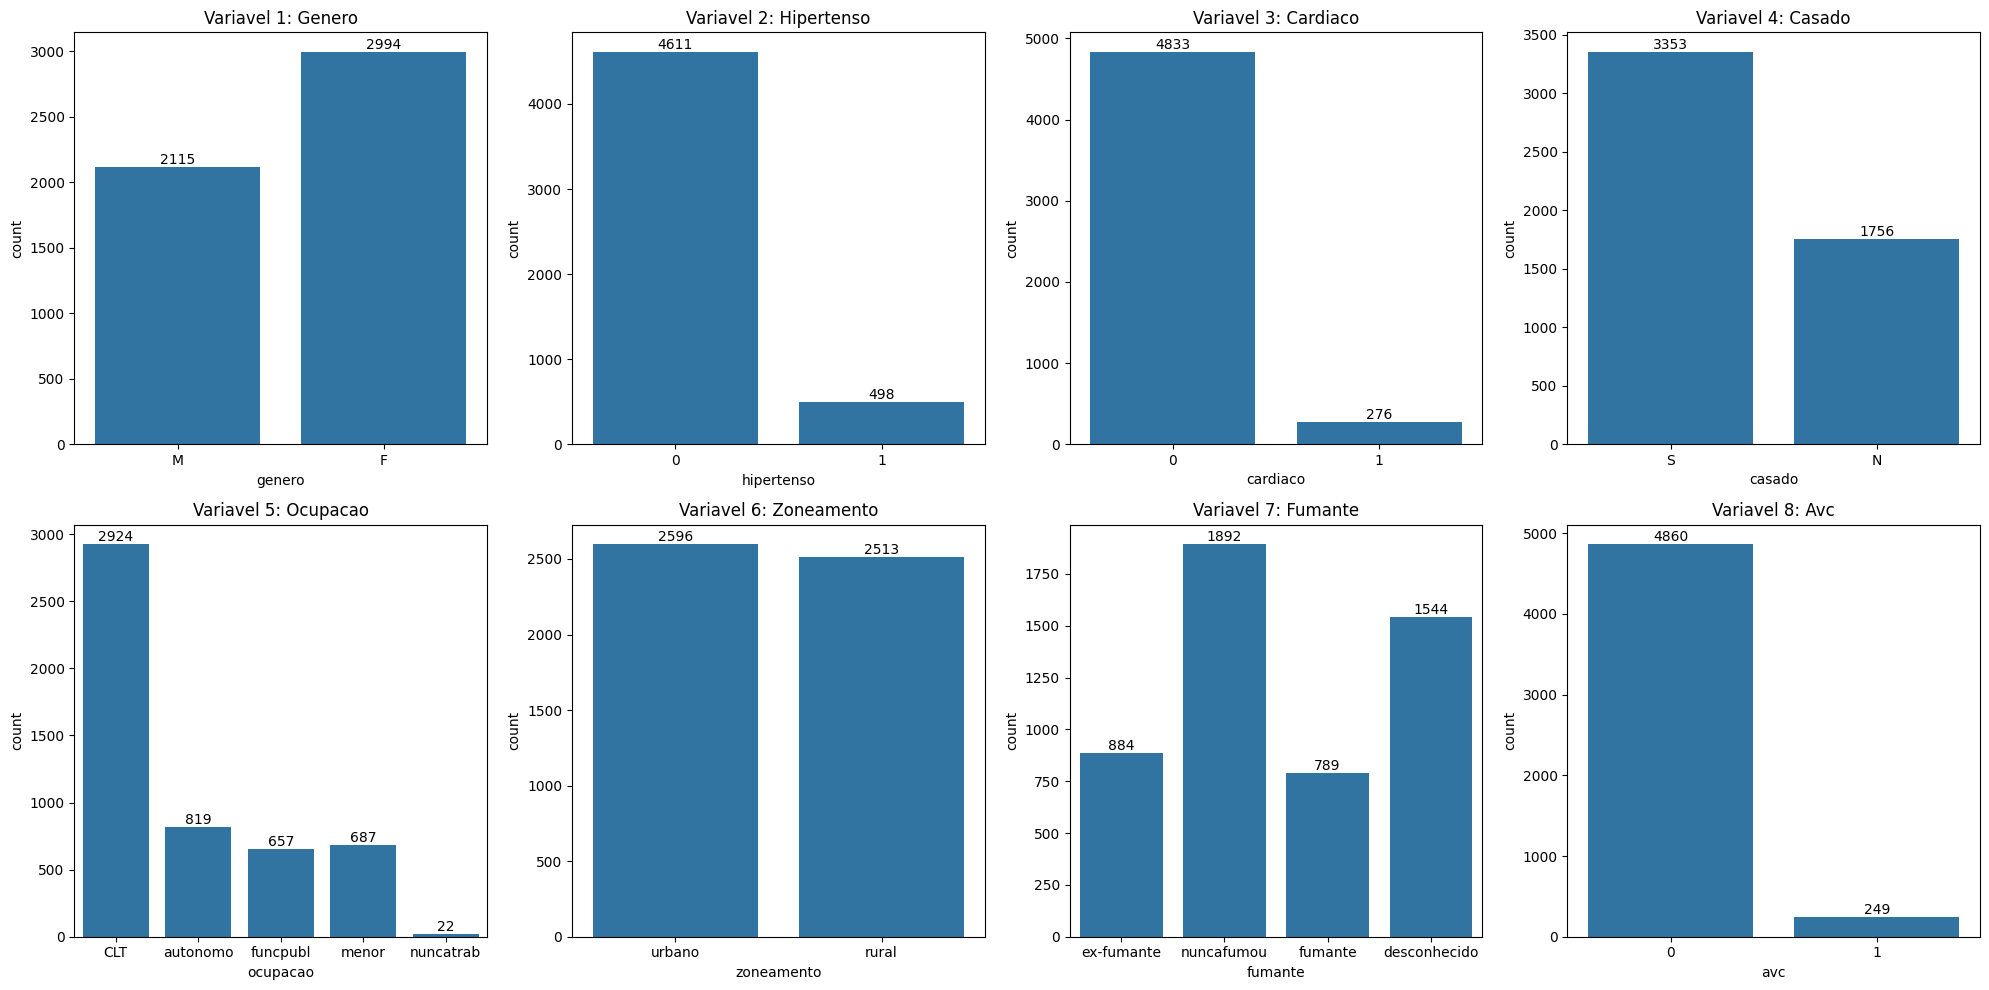

In [40]:
### countplots
plt.figure(figsize=(20,10))
for i in range(len(cat_cols)):
    plt.subplot(2, 4, i+1)
    ax = sns.countplot(data=df, x=cat_cols[i])
    ax.set_title(f'Variavel {i+1}: {cat_cols[i].capitalize()}')
    for j in ax.containers:
        ax.bar_label(j, fmt='%d')
plt.tight_layout();

In [41]:
## análise univariada numérica

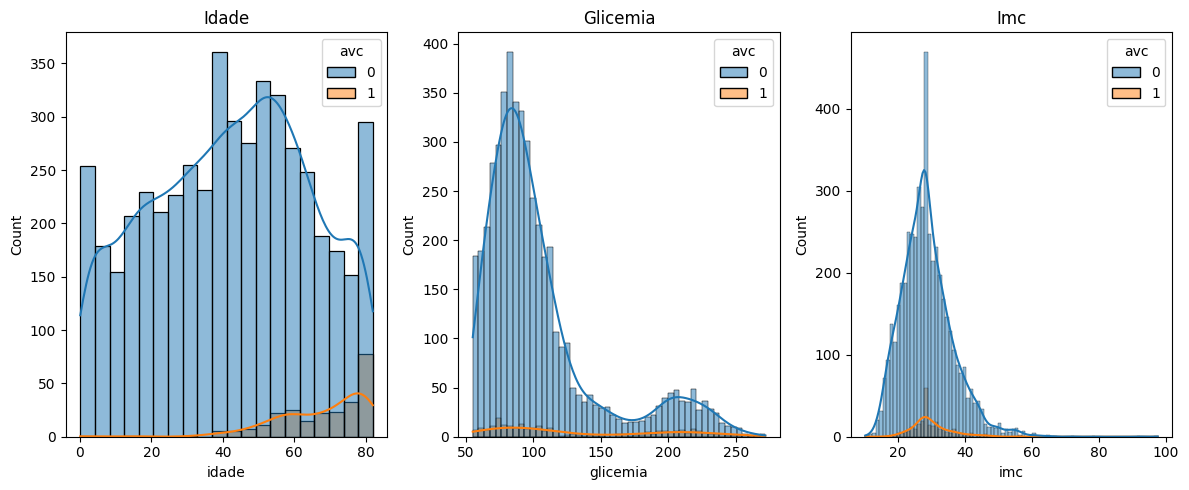

In [42]:
### histogramas
plt.figure(figsize=(12, 5))
for i in range(len(num_cols)):
    plt.subplot(1, 3, i+1)
    #ax = sns.histplot(data=df, x=num_cols[i], kde=True)
    ax = sns.histplot(data=df, x=num_cols[i], kde=True, hue='avc')
    ax.set_title(f'{num_cols[i].capitalize()}')
plt.tight_layout();

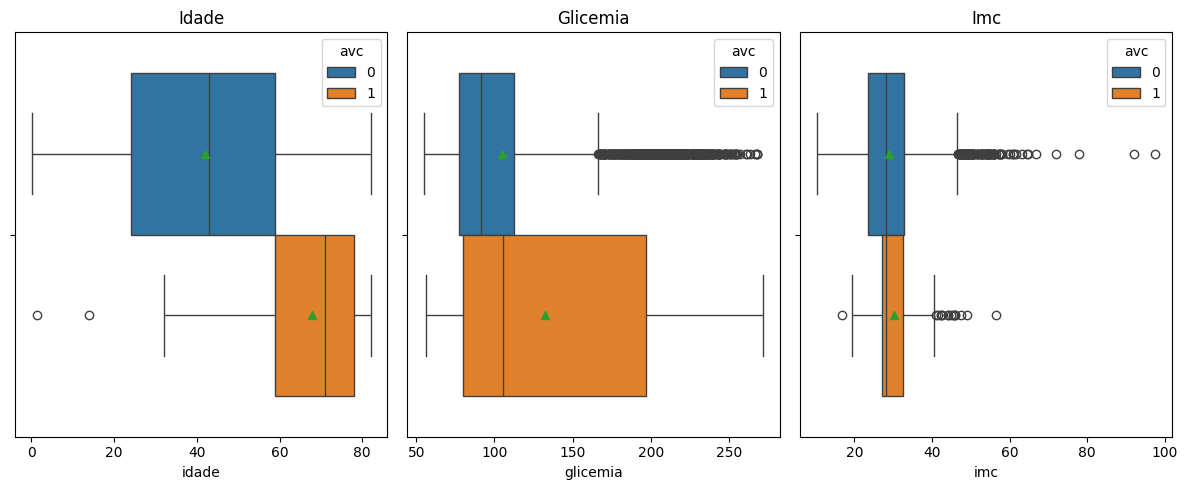

In [43]:
### boxplots
plt.figure(figsize=(12, 5))
for i in range(len(num_cols)):
    plt.subplot(1, 3, i+1)
    #ax = sns.boxplot(data=df, x=num_cols[i], showmeans=True)
    ax = sns.boxplot(data=df, x=num_cols[i], showmeans=True, hue='avc')
    #ax = sns.boxplot(data=df[num_cols[i]], showmeans=True)
    ax.set_title(f'{num_cols[i].capitalize()}')
plt.tight_layout();

In [44]:
### testes de normalidade - Teste de D'Agostino-Pearson
for i in range(len(num_cols)):
    print(f'Variável: {num_cols[i]:8} | p-valor: {normaltest(df[num_cols[i]]).pvalue:.5f}')
    print('Distribuição normal' if normaltest(df[num_cols[i]]).pvalue > .05 else 'Distribuição nao normal')

Variável: idade    | p-valor: 0.00000
Distribuição nao normal
Variável: glicemia | p-valor: 0.00000
Distribuição nao normal
Variável: imc      | p-valor: 0.00000
Distribuição nao normal


In [45]:
### testes de normalidade - visualizações
def normal_viz(data, col):

    """Exibie os gráficos histograma, boxplot e qq-plot para averiguação de normalidade"""

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    sns.histplot(data=data, x=col, kde=True)
    plt.title(f'Histograma {col.capitalize()}')

    plt.subplot(132)
    sns.boxplot(data=data[col].dropna(), showmeans=True)
    plt.title(f'Boxplot {col.capitalize()}')

    plt.subplot(133)
    probplot(x=data[col].dropna(), plot=plt, rvalue=True)
    plt.title(f"QQ-plot D'Agostino-Pearson {col.capitalize()}\n p-valor: {normaltest(df[num_cols[i]]).pvalue:.4f}")
    plt.tight_layout();

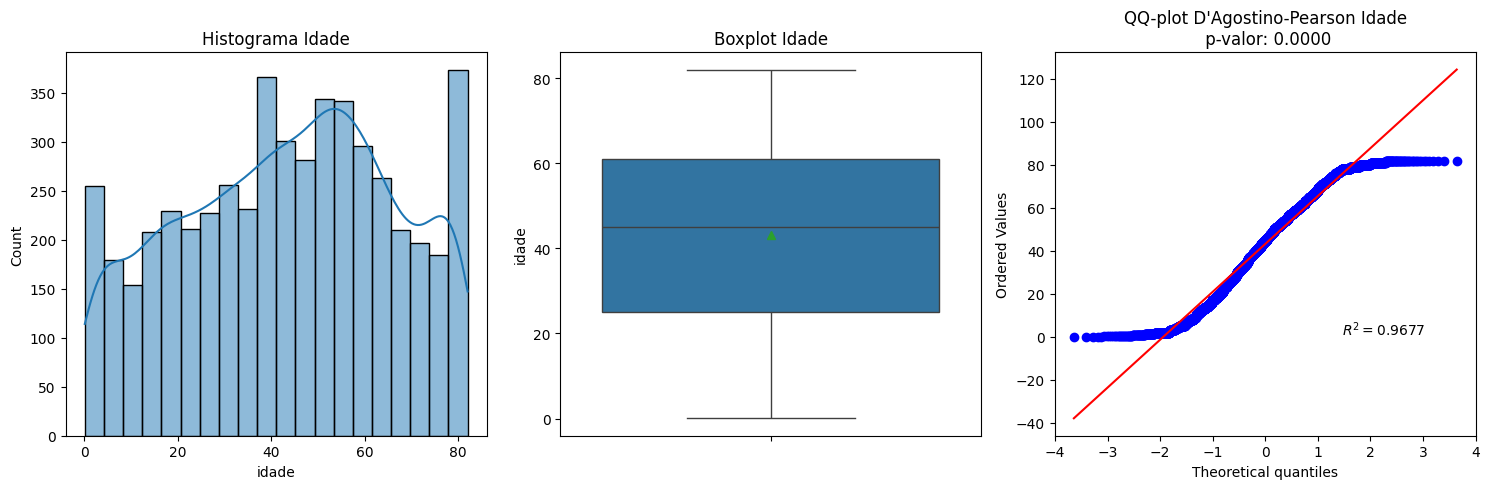

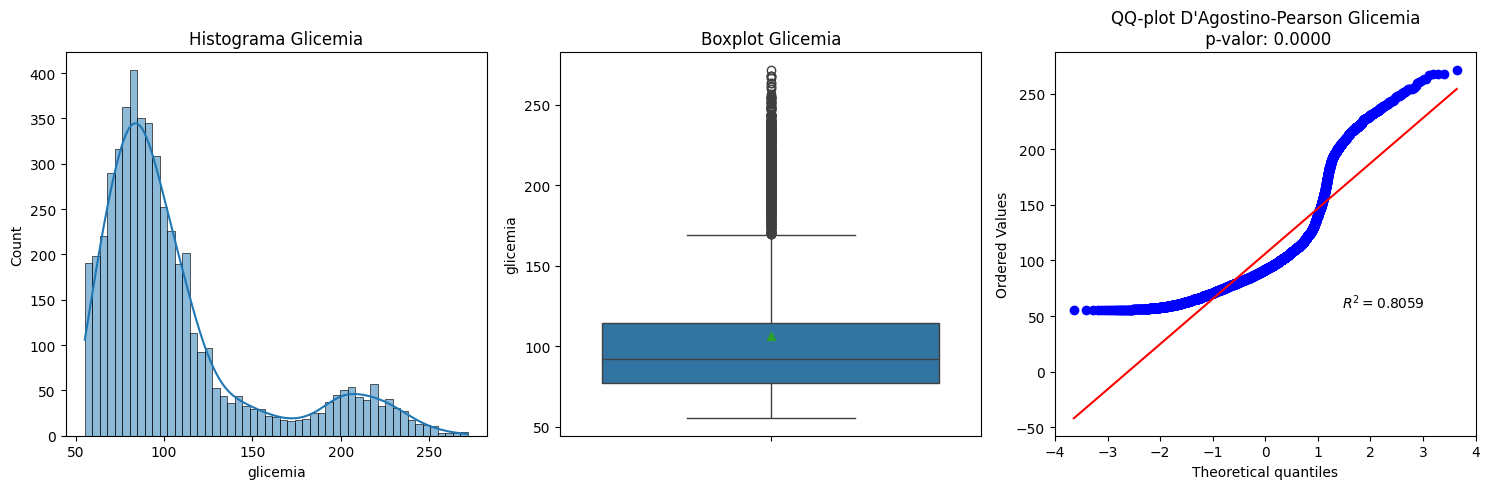

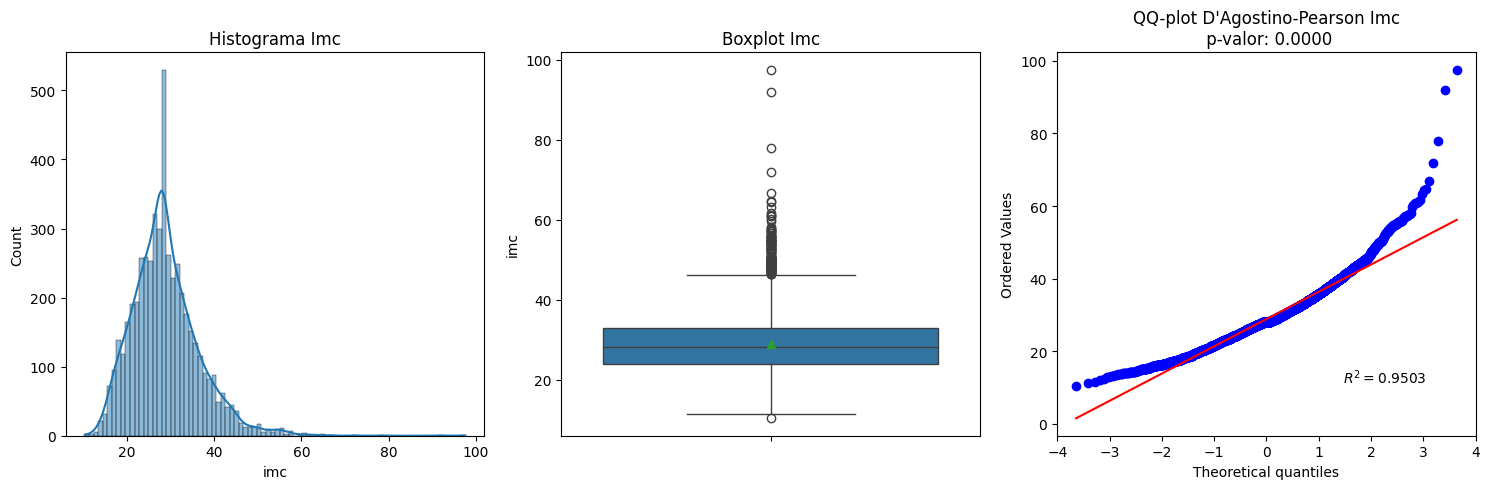

In [46]:
#normal_viz(data=df, col='imc')
for i in range(len(num_cols)):
    normal_viz(data=df, col=num_cols[i])

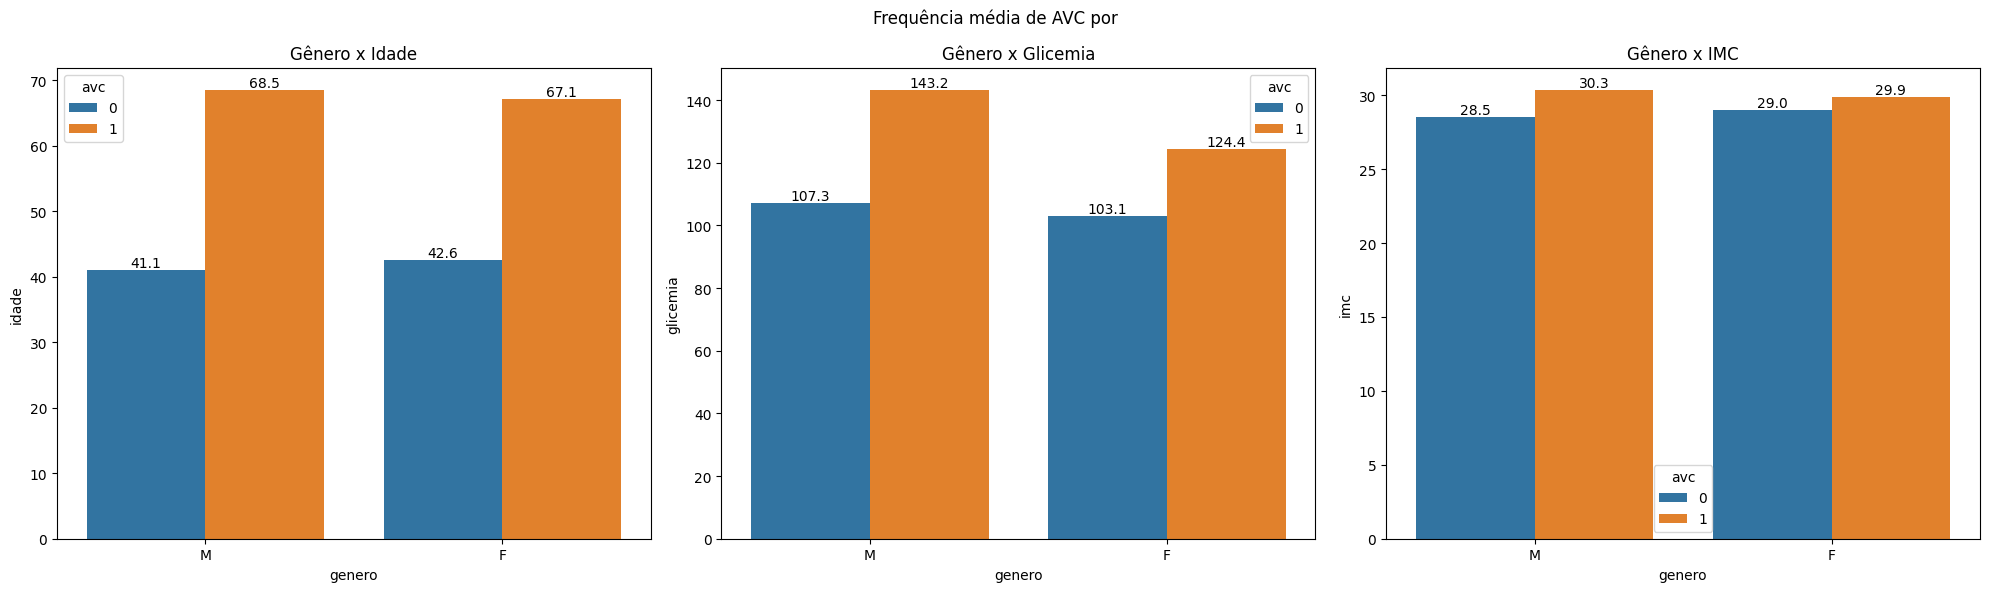

In [47]:
## análise bivariada
### barplots - versão não encapsulada

# genero x idade
plt.figure(figsize=(20, 6))
plt.suptitle('Frequência média de AVC por');

plt.subplot(131)
ax = sns.barplot(data=df, x='genero', y='idade', hue='avc', errorbar=None)
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f')
plt.title('Gênero x Idade')
plt.tight_layout();

# genero x glicemia
plt.subplot(132)
ax = sns.barplot(data=df, x='genero', y='glicemia', hue='avc', errorbar=None)
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f')
plt.title('Gênero x Glicemia')
plt.tight_layout();

# genero x imc
plt.subplot(133)
ax = sns.barplot(data=df, x='genero', y='imc', hue='avc', errorbar=None)
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f')
plt.title('Gênero x IMC')
plt.tight_layout();



In [48]:
# versão encapsulada em função
def bivar_plot(frame, var1, var2, agr):
    ax = sns.barplot(data=frame, x=var1, y=var2, hue=agr, errorbar=None)
    for i in ax.containers:
        ax.bar_label(i, fmt='%.1f')
    plt.title(f'{var1.capitalize()} x {var2.capitalize()}')
    plt.tight_layout();

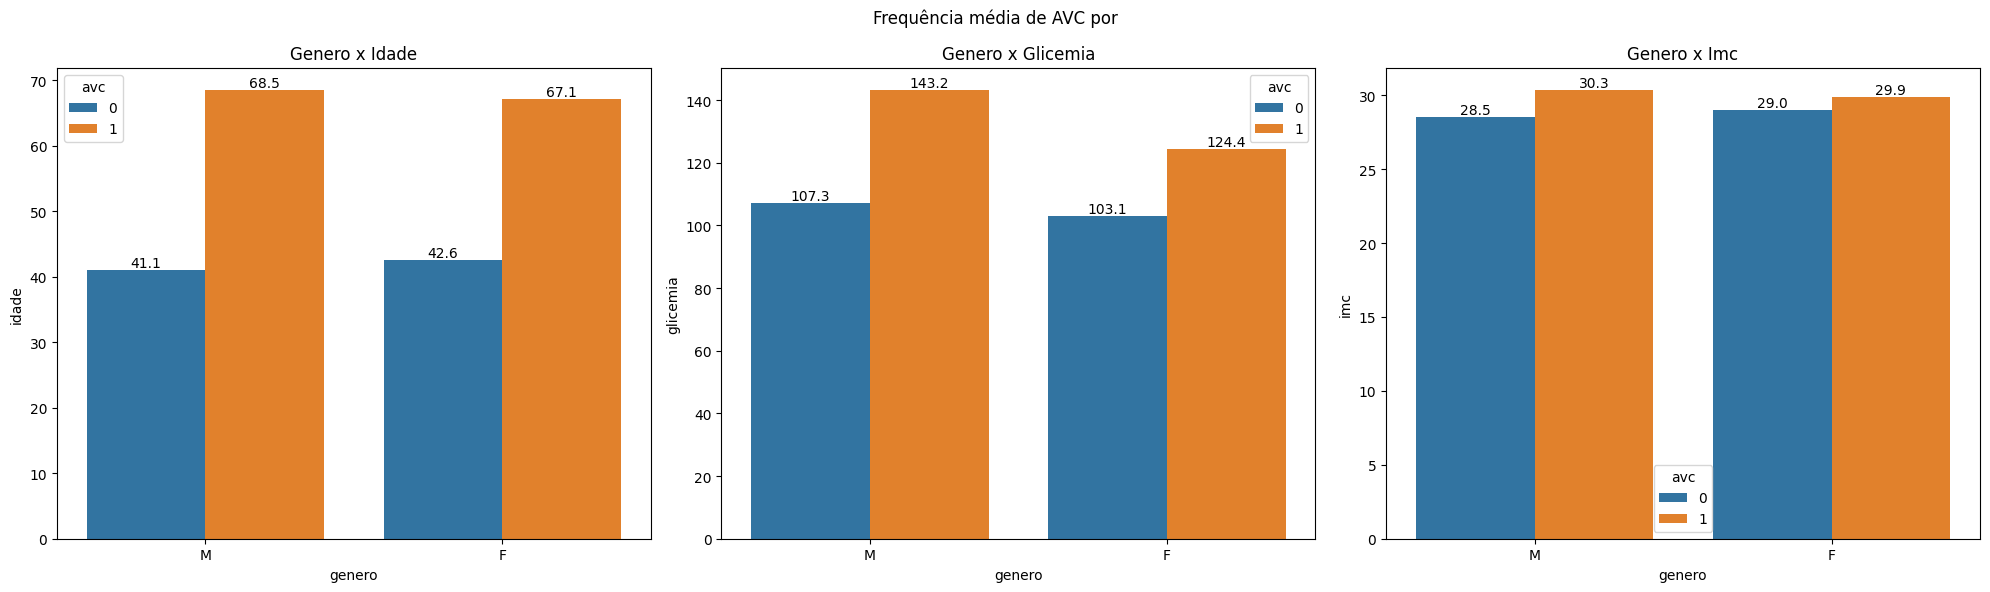

In [49]:
# análise bivariada por gênero
plt.figure(figsize=(20, 6))
plt.suptitle('Frequência média de AVC por');
for i in range(len(num_cols)):
    plt.subplot(1, 3, i+1)
    bivar_plot(df, 'genero', num_cols[i], 'avc');

# fazer analise para as demais variaveis

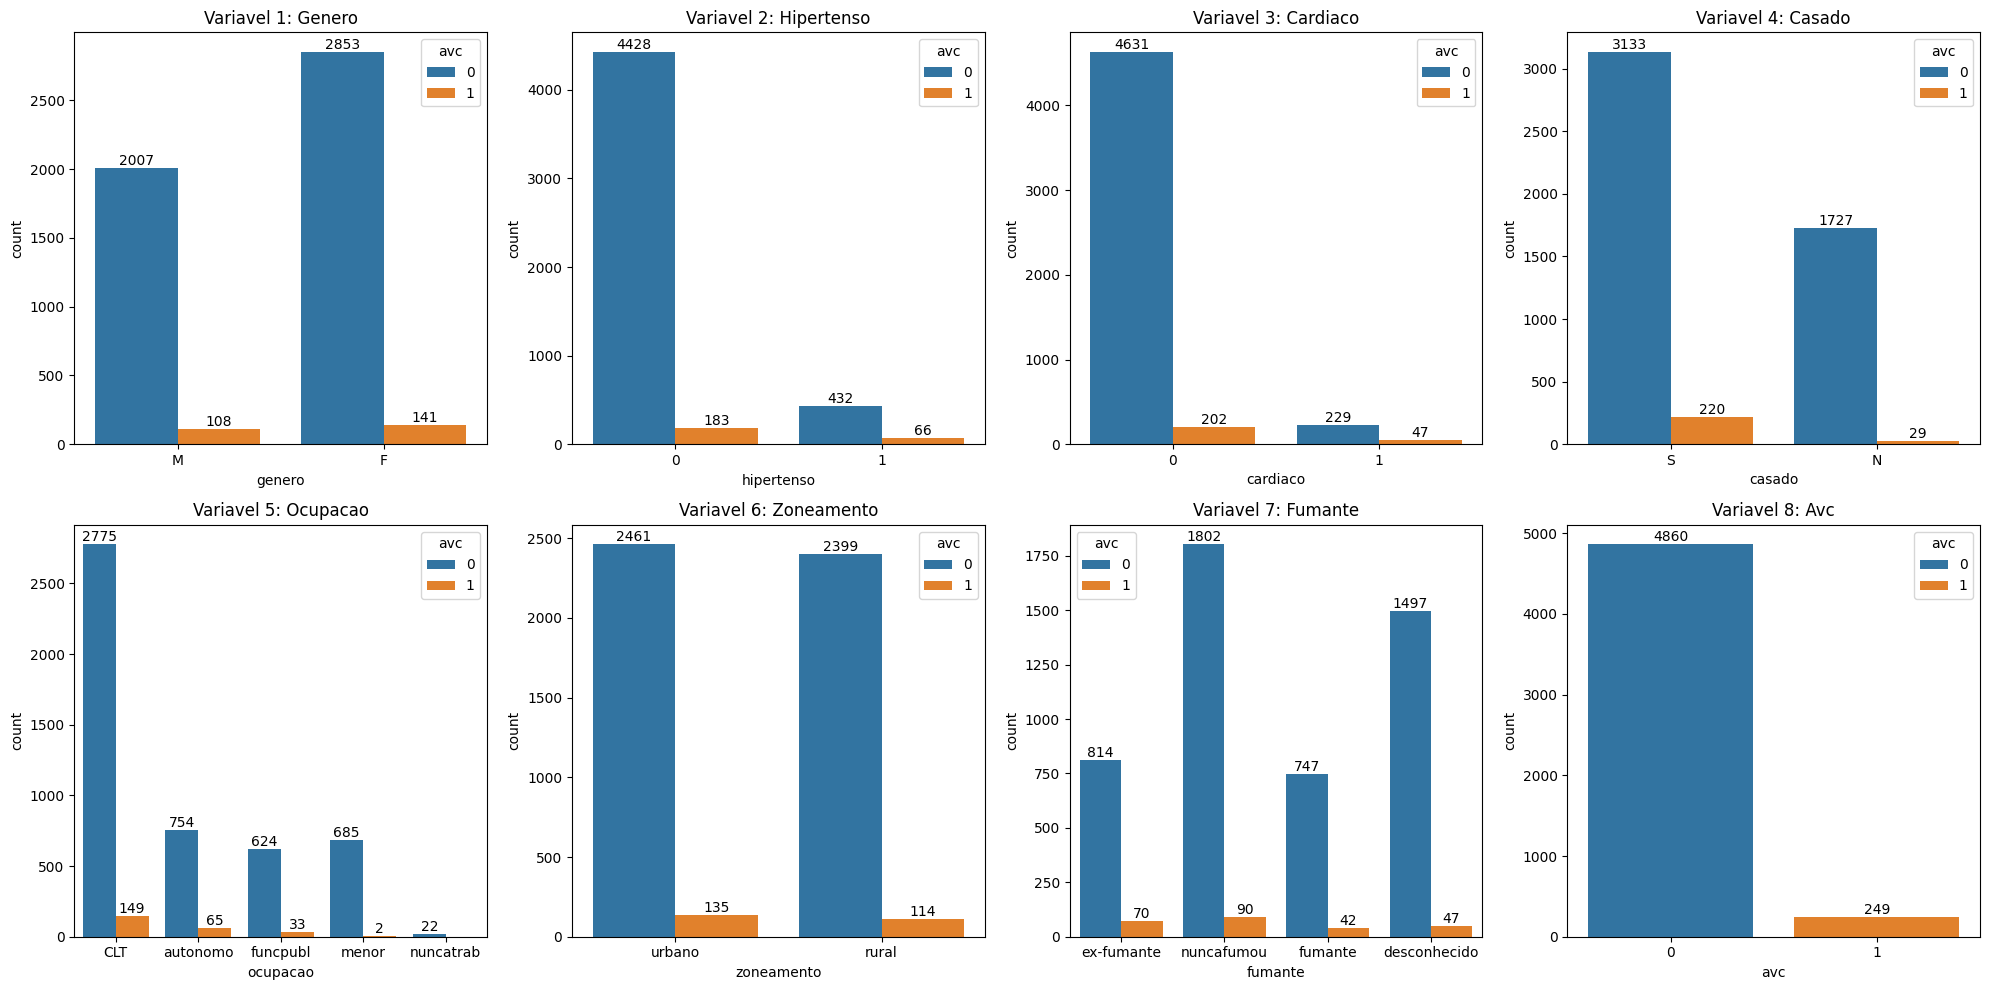

In [50]:
### countplots bivariados

plt.figure(figsize=(20,10))
for i in range(len(cat_cols)):
    plt.subplot(2, 4, i+1)
    ax = sns.countplot(data=df, x=cat_cols[i], hue='avc')
    ax.set_title(f'Variavel {i+1}: {cat_cols[i].capitalize()}')
    for j in ax.containers:
        ax.bar_label(j, fmt='%d')
plt.tight_layout();

In [51]:
### cálculo de coeficientes de correlação

# colunas numericas
num_cols

['idade', 'glicemia', 'imc']

In [52]:
#corr_geral = df[['idade', 'glicemia', 'imc']].corr(method='pearson')
#corr_avc0 = df[['idade', 'glicemia', 'imc']].loc[df['avc']==0].corr(method='pearson')
#corr_avc1 = df[['idade', 'glicemia', 'imc']].loc[df['avc']==1].corr(method='pearson')

corr_geral = df[['idade', 'glicemia', 'imc']].corr(method='spearman')
corr_avc0 = df[['idade', 'glicemia', 'imc']].loc[df['avc']==0].corr(method='spearman')
corr_avc1 = df[['idade', 'glicemia', 'imc']].loc[df['avc']==1].corr(method='spearman')

corr_list = [corr_geral, corr_avc0, corr_avc1]
title_list = ['Geral', 'Sem AVC', 'com AVC']
color_list = ['Blues', 'Greens', 'Oranges']

In [53]:
### matriz de correlação
def corr_mat_plot(data, color, title):
    ax = sns.heatmap(data=data, cbar=False, annot=True, cmap=color)
    plt.title(title)
    return ax

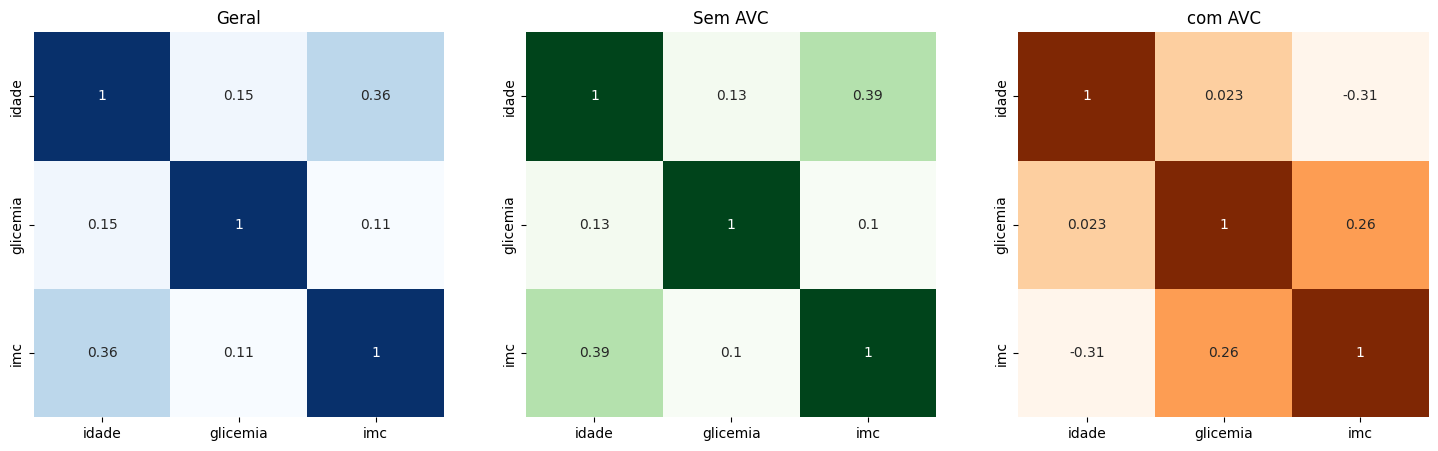

In [54]:
plt.figure(figsize=(18, 5))
for i in range(len(corr_list)):
    plt.subplot(1, 3, i+1)
    corr_mat_plot(data=corr_list[i], color=color_list[i], title=title_list[i]);

In [55]:
def corr_mat_plot2(data, title, color, method):
    corr_geral = df[['idade', 'glicemia', 'imc']].corr(method=method)
    corr_avc0 = df[['idade', 'glicemia', 'imc']].loc[df['avc']==0].corr(method=method)
    corr_avc1 = df[['idade', 'glicemia', 'imc']].loc[df['avc']==1].corr(method=method)

    corr_list = [corr_geral, corr_avc0, corr_avc1]
    title_list = ['Geral', 'Sem AVC', 'com AVC']
    color_list = ['Blues', 'Greens', 'Oranges']

    ax = sns.heatmap(data=data, cbar=False, annot=True, cmap=color)
    plt.title(title)
    return ax

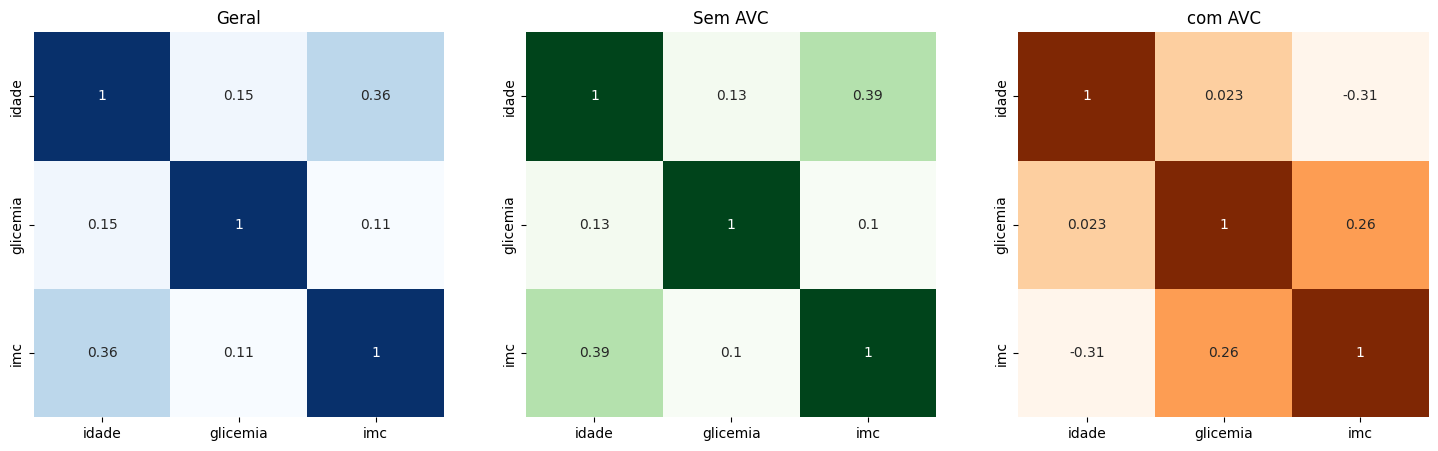

In [56]:
plt.figure(figsize=(18, 5))
for i in range(len(corr_list)):
    plt.subplot(1, 3, i+1)
    corr_mat_plot2(data=corr_list[i], color=color_list[i], title=title_list[i], method='pearson');

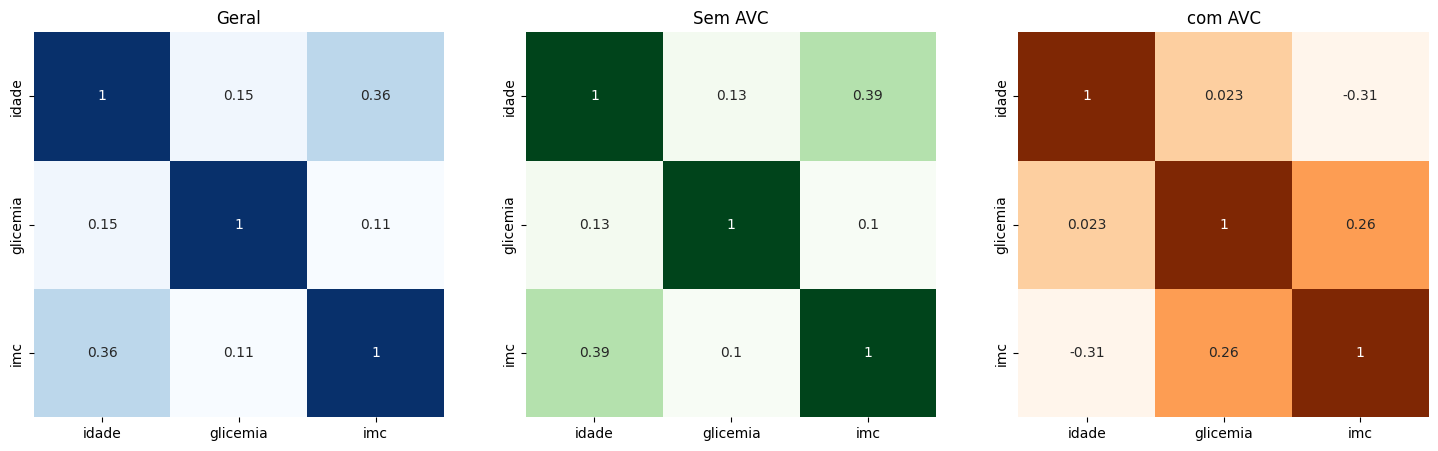

In [57]:
plt.figure(figsize=(18, 5))
for i in range(len(corr_list)):
    plt.subplot(1, 3, i+1)
    corr_mat_plot2(data=corr_list[i], color=color_list[i], title=title_list[i], method='spearman');

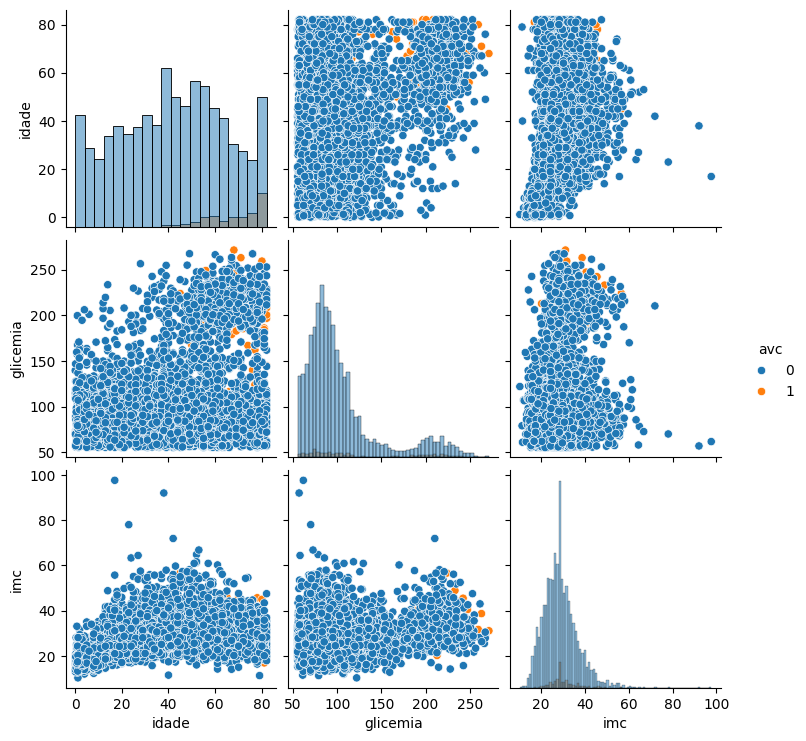

In [58]:
### pairplots
#sns.pairplot(data=df[['idade', 'glicemia', 'imc']], diag_kind='kde');
sns.pairplot(data=df[['idade', 'glicemia', 'imc', 'avc']], diag_kind='hist', hue='avc');
#sns.pairplot(data=df[['idade', 'glicemia', 'imc']].loc[df['avc']==0], diag_kind='kde');
#sns.pairplot(data=df[['idade', 'glicemia', 'imc']].loc[df['avc']==1], diag_kind='kde');

### 3. Machine learning

#### 3.1. Modelagem preditiva com dados desbalanceados

##### 3.1.1. Encoding de variáveis

In [59]:
df.head()

,genero,idade,hipertenso,cardiaco,casado,ocupacao,zoneamento,glicemia,imc,fumante,avc
0,M,67.0,0,1,S,CLT,urbano,228.69,36.6,ex-fumante,1
1,F,61.0,0,0,S,autonomo,rural,202.21,28.1,nuncafumou,1
2,M,80.0,0,1,S,CLT,rural,105.92,32.5,nuncafumou,1
3,F,49.0,0,0,S,CLT,urbano,171.23,34.4,fumante,1
4,F,79.0,1,0,S,autonomo,rural,174.12,24.0,nuncafumou,1


In [60]:
# encoding de variáveis
# criação de novos datasets

df_le = df.copy()
df_ohe = df.copy()

In [61]:
cat_cols[:-1]
df_ohe = pd.get_dummies(data=df_ohe, columns=cat_cols[:-1], dtype=int, drop_first=True)
df_ohe.to_csv('dataset_onehot-encoded.csv', index=False)
df_ohe.head()

,idade,glicemia,imc,avc,genero_M,hipertenso_1,cardiaco_1,casado_S,ocupacao_autonomo,ocupacao_funcpubl,ocupacao_menor,ocupacao_nuncatrab,zoneamento_urbano,fumante_ex-fumante,fumante_fumante,fumante_nuncafumou
0,67.0,228.69,36.6,1,1,0,1,1,0,0,0,0,1,1,0,0
1,61.0,202.21,28.1,1,0,0,0,1,1,0,0,0,0,0,0,1
2,80.0,105.92,32.5,1,1,0,1,1,0,0,0,0,0,0,0,1
3,49.0,171.23,34.4,1,0,0,0,1,0,0,0,0,1,0,1,0
4,79.0,174.12,24.0,1,0,1,0,1,1,0,0,0,0,0,0,1


In [62]:
df['fumante'].unique()

array(['ex-fumante', 'nuncafumou', 'fumante', 'desconhecido'],
      dtype=object)

In [63]:
df_le['genero'].replace({'M':0, 'F':1}, inplace=True)
df_le['casado'].replace({'N':0, 'S':1}, inplace=True)
df_le['ocupacao'].replace({'CLT':0, 'autonomo':1, 'funcpubl':2,
                           'menor':3, 'nuncatrab':4}, inplace=True)
df_le['zoneamento'].replace({'rural': 0, 'urbano': 1}, inplace=True)
df_le['fumante'].replace({'ex-fumante':0, 'nuncafumou':1,
                            'fumante':2, 'desconhecido':3}, inplace=True)

#df_le.to_csv('dataset_label-encoded.csv', index=False)
df_le.head()

,genero,idade,hipertenso,cardiaco,casado,ocupacao,zoneamento,glicemia,imc,fumante,avc
0,0,67.0,0,1,1,0,1,228.69,36.6,0,1
1,1,61.0,0,0,1,1,0,202.21,28.1,1,1
2,0,80.0,0,1,1,0,0,105.92,32.5,1,1
3,1,49.0,0,0,1,0,1,171.23,34.4,2,1
4,1,79.0,1,0,1,1,0,174.12,24.0,1,1


In [64]:
# Verificacao da variavel alvo nos datasets

#df['avc'] == df_ohe['avc']
#df['avc'] == df_le['avc']
#df_ohe['avc'] == df_le['avc']

In [65]:
X_ohe = df_ohe.drop(labels='avc', axis=1)
X_le = df_le.drop(labels='avc', axis=1)
y = df['avc']

##### 3.1.2. Divisão treino-teste (train test split)

In [66]:
# Divisao treino-teste

# ohe
Xtrain_ohe, Xtest_ohe, ytrain_ohe, ytest_ohe = train_test_split(X_ohe, y, test_size=.2, stratify=y, random_state=42)
# le
Xtrain_le, Xtest_le, ytrain_le, ytest_le = train_test_split(X_le, y, test_size=.2, stratify=y, random_state=42)

##### 3.1.3. Escalonamento dos dados

In [67]:
# Escalonamento dos dados
cols_to_scale = ['idade', 'glicemia', 'imc']

sc = MinMaxScaler()

Xtrain_ohe_sc = Xtrain_ohe.copy()
Xtest_ohe_sc = Xtest_ohe.copy()
Xtrain_ohe_sc[cols_to_scale] = sc.fit_transform(Xtrain_ohe_sc[cols_to_scale])
Xtest_ohe_sc[cols_to_scale] = sc.transform(Xtest_ohe_sc[cols_to_scale])

Xtrain_le_sc = Xtrain_le.copy()
Xtest_le_sc = Xtest_le.copy()
Xtrain_le_sc[cols_to_scale] = sc.fit_transform(Xtrain_le_sc[cols_to_scale])
Xtest_le_sc[cols_to_scale] = sc.transform(Xtest_le_sc[cols_to_scale])

##### 3.1.4. Treinamento do modelo

In [68]:
# Treinamento dos modelos
model_ohe = LogisticRegression()
model_le = LogisticRegression()

model_ohe.fit(Xtrain_ohe_sc, ytrain_ohe)
model_le.fit(Xtrain_le_sc, ytrain_le)

LogisticRegression()

##### 3.1.5. Previsões e métricas de desempenho

In [69]:
# previsoes
ypred_ohe = model_ohe.predict(Xtest_ohe_sc)
ypred_proba_ohe = model_ohe.predict_proba(Xtest_ohe_sc)[:, 1]

ypred_le = model_le.predict(Xtest_le_sc)
ypred_proba_le = model_le.predict_proba(Xtest_le_sc)[:, 1]

In [70]:
# métricas
def metrics(Xtrain, model, ytest, ypred, ypred_proba):
    print(classification_report(ytest, ypred))

    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    cm = confusion_matrix(ytest, ypred)
    sns.heatmap(data=cm, annot=True, fmt='d', cbar=False, cmap='Blues')
    plt.title('Matriz de confusão \nRegressão logística AVC')
    plt.xlabel('Previsto')
    plt.ylabel('Real');

    plt.subplot(132)
    auc = roc_auc_score(ytest, ypred_proba)
    fpr, tpr, _ = roc_curve(ytest, ypred_proba)
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Classificador Aleatório")
    plt.xlabel("Taxa de Falsos Positivos")
    plt.ylabel("Taxa de Verdadeiros Positivos")
    plt.title("Curva ROC")
    plt.legend();

    plt.subplot(133)
    # Criar DataFrame com coeficientes
    coef_df = pd.DataFrame({'feature': Xtrain.columns,
                        'coefficient': model.coef_[0]})\
                            .sort_values(by='coefficient',
                             key=abs, ascending=False)

    # Top 10 features mais importantes
    top_coef = coef_df.head(5)

    ax = sns.barplot(data=top_coef, x='coefficient', y='feature', palette='viridis')
    plt.title("Top 5 Features - Coeficientes da Regressão Logística")
    plt.xlabel("Coeficiente")
    plt.tight_layout();
    for i in ax.containers:
        ax.bar_label(i, fmt='%.1f')

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



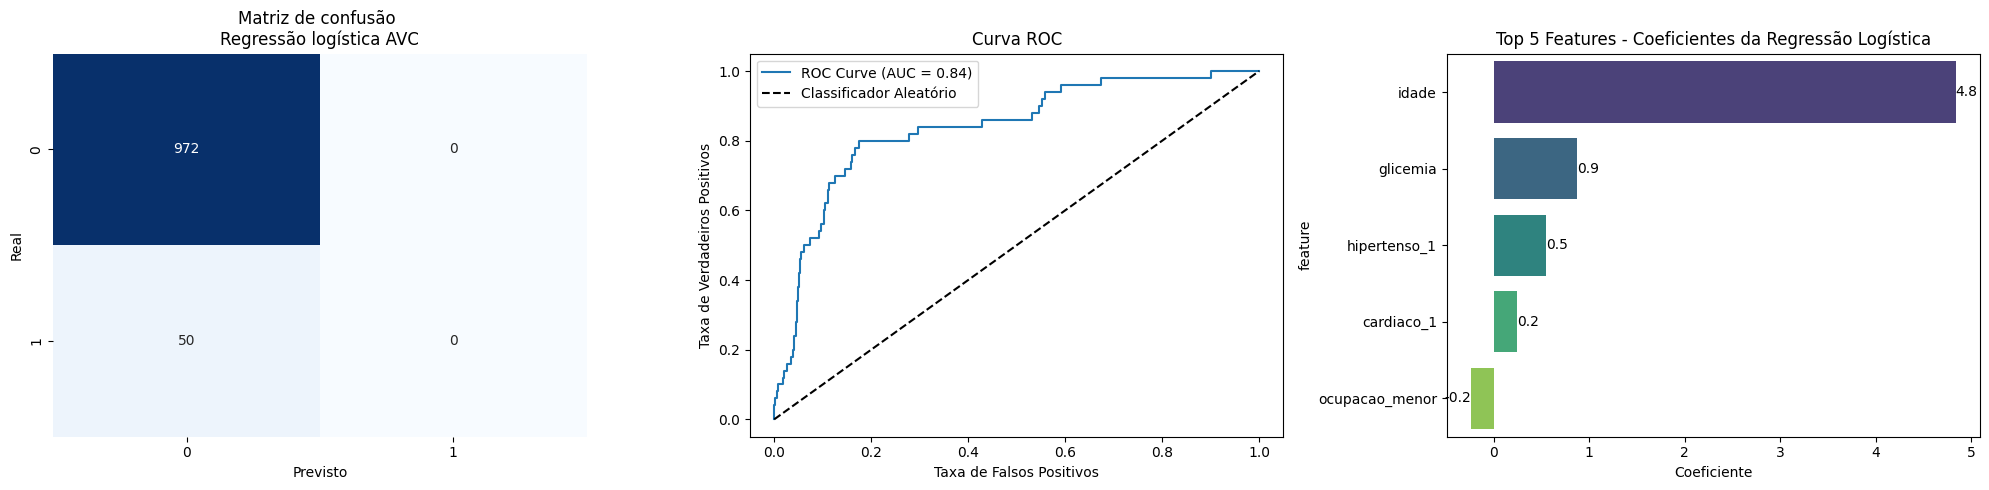

In [71]:
metrics_ohe = metrics(Xtrain_ohe_sc, model_ohe, ytest_ohe, ypred_ohe, ypred_proba_ohe)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



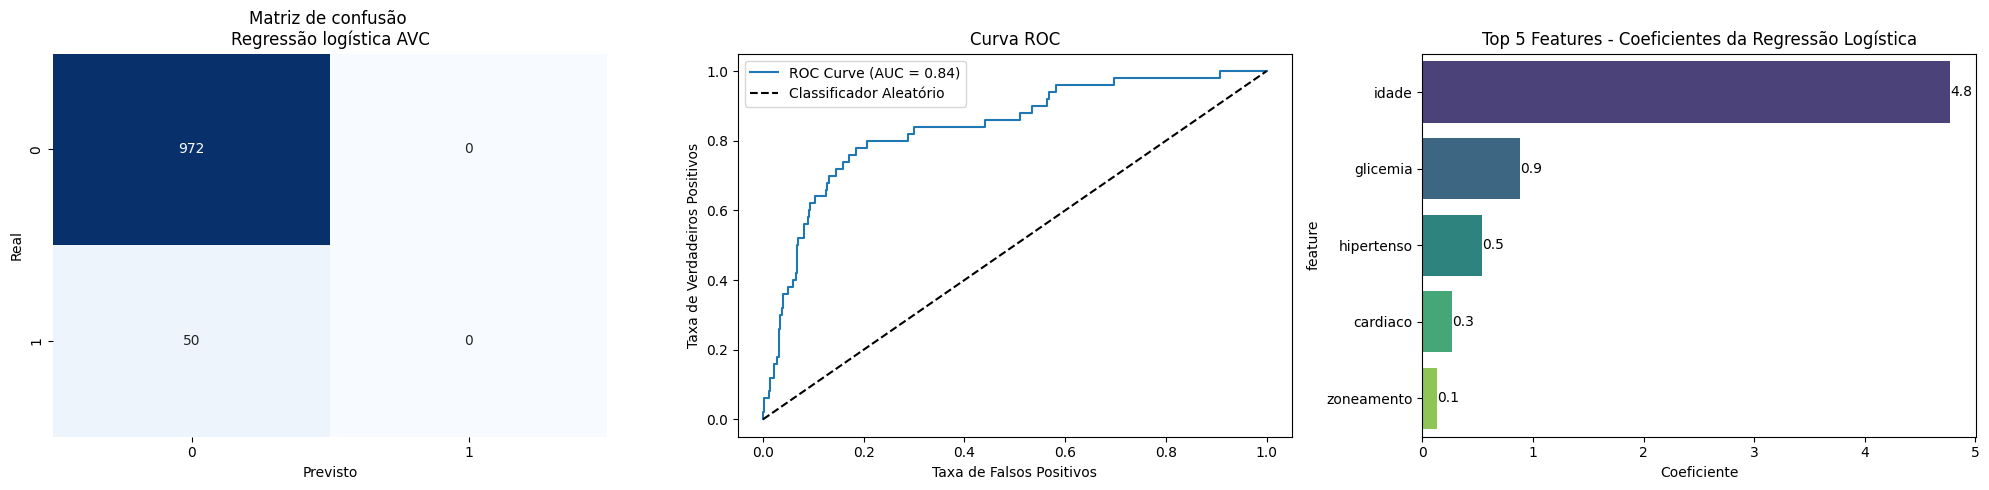

In [72]:
metrics_le = metrics(Xtrain_le_sc, model_le, ytest_le, ypred_le, ypred_proba_le)

#### 3.2. Treinamento e avaliação com dados balanceados

##### 3.2.1. Balanceamento dos dados da variável alvo

In [73]:
# SMOTE le
X_le = df_le.drop('avc', axis=1)
y_le = df_le['avc']

##### 3.2.2. Divisão treino-teste, balanceamento e escalonamento

In [74]:
Xtrain_le, Xtest_le, ytrain_le, ytest_le = train_test_split(X_le, y_le, test_size=.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
Xtrain_le_smote, ytrain_le_smote = smote.fit_resample(Xtrain_le, ytrain_le)

print(f'Antes: X = {Xtrain_le.shape} | y = {ytrain_le.shape}')
print(f'Depois: X = {Xtrain_le_smote.shape} | y = {ytrain_le_smote.shape}')

Antes: X = (4087, 10) | y = (4087,)
Depois: X = (7776, 10) | y = (7776,)


In [75]:
sc = MinMaxScaler()

Xtrain_le_sc = Xtrain_le_smote.copy()
Xtest_le_sc = Xtest_le.copy()
Xtrain_le_sc[cols_to_scale] = sc.fit_transform(Xtrain_le_sc[cols_to_scale])
Xtest_le_sc[cols_to_scale] = sc.transform(Xtest_le_sc[cols_to_scale])

##### 3.2.3. Treinamento do modelo e métricas de desempenho

In [76]:
model_le = LogisticRegression(random_state=42)
model_le.fit(Xtrain_le_sc, ytrain_le_smote)

ypred_le = model_le.predict(Xtest_le_sc)
ypred_le_proba = model_le.predict_proba(Xtest_le_sc)[:, 1]

              precision    recall  f1-score   support

           0       0.98      0.79      0.88       972
           1       0.15      0.68      0.24        50

    accuracy                           0.79      1022
   macro avg       0.56      0.74      0.56      1022
weighted avg       0.94      0.79      0.85      1022



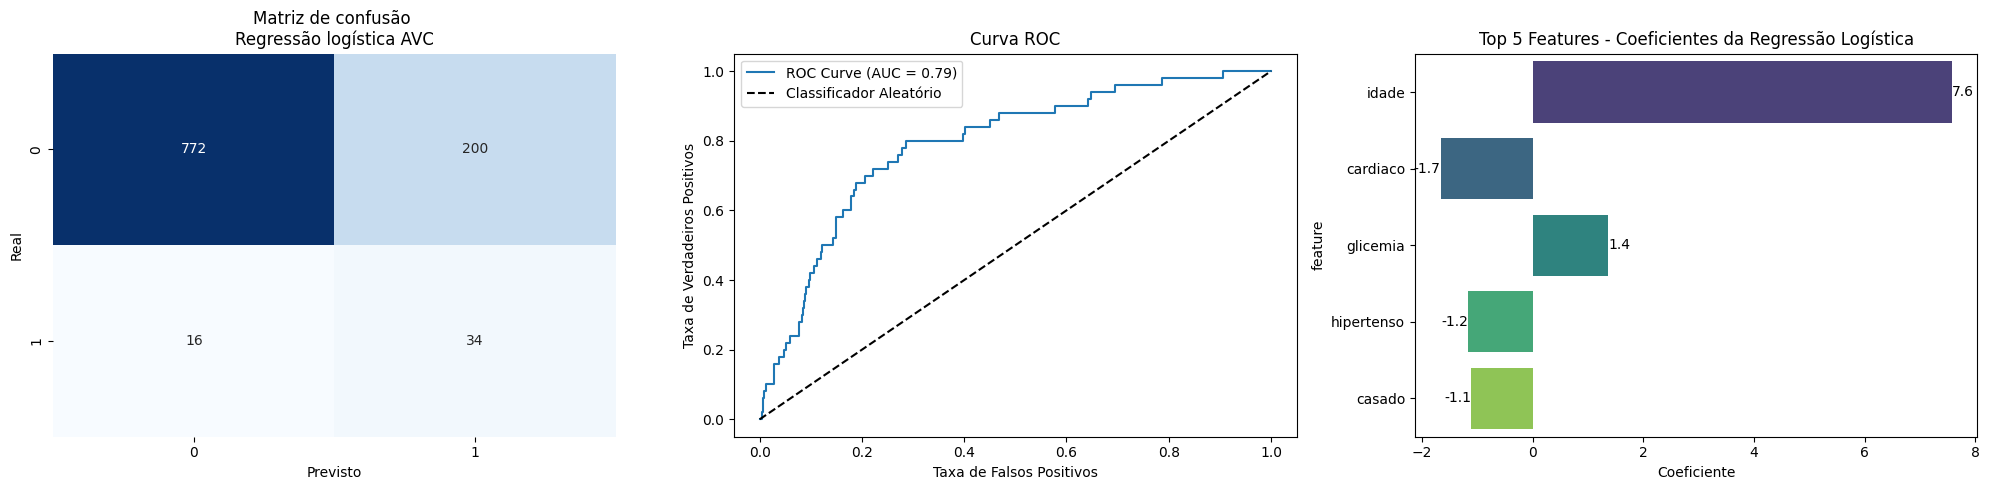

In [77]:
metrics_smote_le = metrics(Xtrain_le_sc, model_le, ytest_le, ypred_le, ypred_le_proba)

##### 3.2.4. Modelagem preditiva do dataset codificado com OHE

Antes: X = (4087, 15) | y = (4087,)
Depois: X = (7776, 15) | y = (7776,)
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       972
           1       0.15      0.56      0.24        50

    accuracy                           0.82      1022
   macro avg       0.56      0.70      0.57      1022
weighted avg       0.93      0.82      0.87      1022



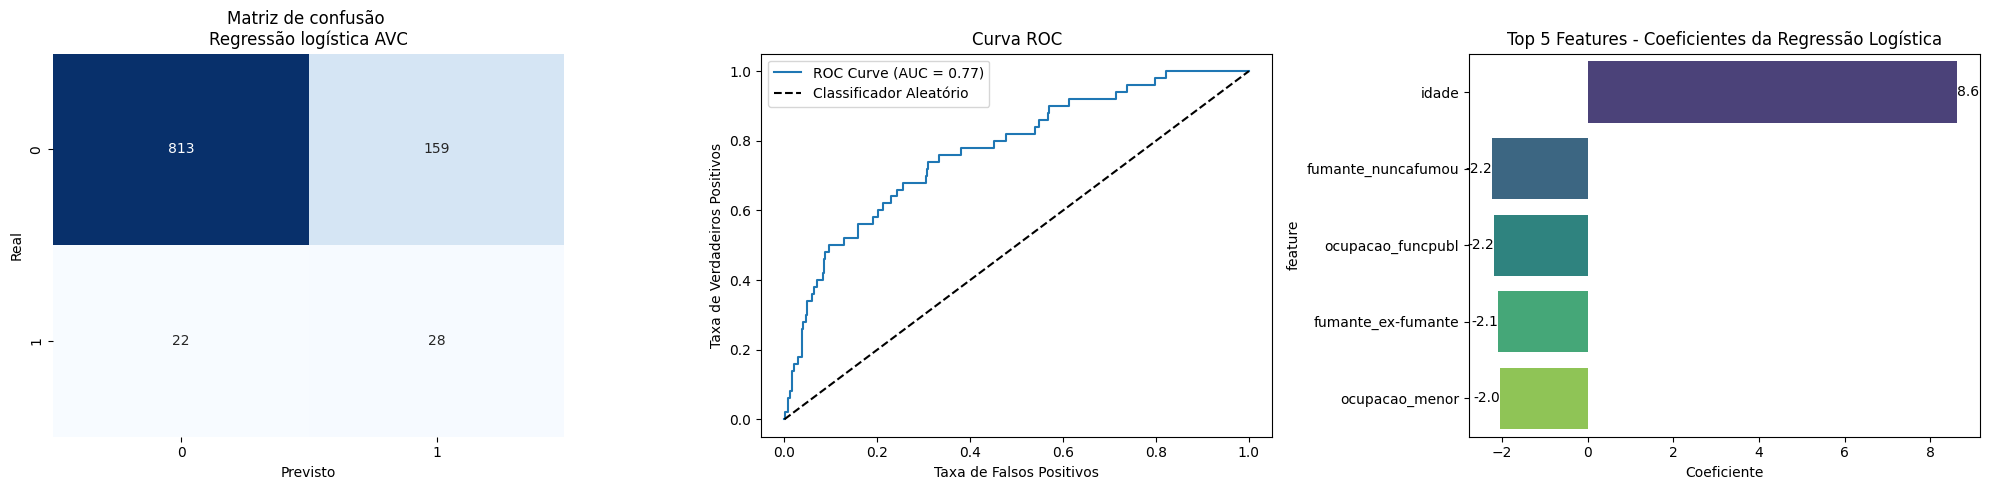

In [78]:
# SMOTE ohe
# variáveis X e y OHE
Xohe = df_ohe.drop('avc', axis=1)
y_ohe = df_ohe['avc']

# divisão treino teste, balanceamento e escalonamento
Xtrain_ohe, Xtest_ohe, ytrain_ohe, ytest_ohe = train_test_split(X_ohe, y_ohe, test_size=.2, random_state=42, stratify=y)

smote_ohe = SMOTE(random_state=42)
Xtrain_ohe_smote, ytrain_ohe_smote = smote_ohe.fit_resample(Xtrain_ohe, ytrain_ohe)

print(f'Antes: X = {Xtrain_ohe.shape} | y = {ytrain_ohe.shape}')
print(f'Depois: X = {Xtrain_ohe_smote.shape} | y = {ytrain_ohe_smote.shape}')

sc = MinMaxScaler()

Xtrain_ohe_sc = Xtrain_ohe_smote.copy()
Xtest_ohe_sc = Xtest_ohe.copy()
Xtrain_ohe_sc[cols_to_scale] = sc.fit_transform(Xtrain_ohe_sc[cols_to_scale])
Xtest_ohe_sc[cols_to_scale] = sc.transform(Xtest_ohe_sc[cols_to_scale])

# treinamento do modelo e previsões
model_ohe = LogisticRegression(random_state=42)
model_ohe.fit(Xtrain_ohe_sc, ytrain_ohe_smote)

ypred_ohe = model_ohe.predict(Xtest_ohe_sc)
ypred_ohe_proba = model_ohe.predict_proba(Xtest_ohe_sc)[:, 1]

# métricas de desempenho
metrics_smote_ohe = metrics(Xtrain_ohe_sc, model_ohe, ytest_ohe, ypred_ohe, ypred_ohe_proba)